# 모두의 딥러닝 개정 3판 
## 20장 전이 학습을 통해 딥러닝의 성능 극대화하기

- 미세 조정(fine tuning):
  대규모 데이터셋에서 학습된 기존의 네트워크를 불러온 뒤   
  CNN 모델의 앞쪽을 이 네트워크로 채우기   
  뒤쪽 레이어와 내 프로젝트 연결(이때 잘 맞물리도록 미세조정 발생)

In [1]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from tensorflow.keras.applications import VGG16

In [3]:
BATCH_SIZE = 5

In [4]:
# 학습셋의 변형 설정하기
# 데이터 특성에 맞게 항목을 골라써야함
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정(0~1 값 고정)
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.(정확히 10%가 아님)
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )

train_generator = train_datagen.flow_from_directory(
       './data/train',   # 학습셋이 있는 폴더의 위치
       target_size=(150, 150),
       batch_size=BATCH_SIZE,
       class_mode='binary')  # 이진분류 (정상0/치매1)

# 테스트셋 정규화
test_datagen = ImageDataGenerator(rescale=1./255)  

test_generator = test_datagen.flow_from_directory(
       './data/test',   # 테스트셋이 있는 폴더의 위치
       target_size=(150, 150),
       batch_size=BATCH_SIZE,
       class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [5]:
# VGG16 모델 불러오기
# include_top=False : fine-tuning한 내 레이어(로컬 네트워크)를 연결하기 위해
transfer_model = VGG16(weights='imagenet', include_top=False,
                      input_shape=(150,150,3))
transfer_model.trainable = False
transfer_model.summary()

58889256/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [6]:
# 연결할 모델 생성(로컬 네트워크 만들기)
finetune_model = models.Sequential()

finetune_model.add(transfer_model)
finetune_model.add(layers.Flatten())
finetune_model.add(layers.Dense(64))
finetune_model.add(layers.Activation('relu'))
finetune_model.add(layers.Dropout(0.5))
finetune_model.add(layers.Dense(1))
finetune_model.add(layers.Activation('sigmoid'))

finetune_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 activation_1 (Activation)   (None, 1)                 0

In [7]:
finetune_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=0.0002),  # optimizers -> 학습률 지정
                  metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [8]:
history = finetune_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
32/32 [==============================] - 17s 512ms/step - loss: 0.8402 - accuracy: 0.4812 - val_loss: 0.6212 - val_accuracy: 0.5500
Epoch 2/20
32/32 [==============================] - 15s 470ms/step - loss: 0.5752 - accuracy: 0.7437 - val_loss: 0.5101 - val_accuracy: 0.7667
Epoch 3/20
32/32 [==============================] - 15s 473ms/step - loss: 0.4663 - accuracy: 0.8062 - val_loss: 0.4494 - val_accuracy: 0.8250
Epoch 4/20
32/32 [==============================] - 15s 471ms/step - loss: 0.4317 - accuracy: 0.8188 - val_loss: 0.3864 - val_accuracy: 0.9167
Epoch 5/20
32/32 [==============================] - 15s 475ms/step - loss: 0.3710 - accuracy: 0.8562 - val_loss: 0.3478 - val_accuracy: 0.8833
Epoch 6/20
32/32 [==============================] - 15s 468ms/step - loss: 0.3596 - accuracy: 0.8375 - val_loss: 0.3920 - val_accuracy: 0.8250
Epoch 7/20
32/32 [==============================] - 15s 462ms/step - loss: 0.3686 - accuracy: 0.8562 - val_loss: 0.3146 - val_accuracy: 0.9167

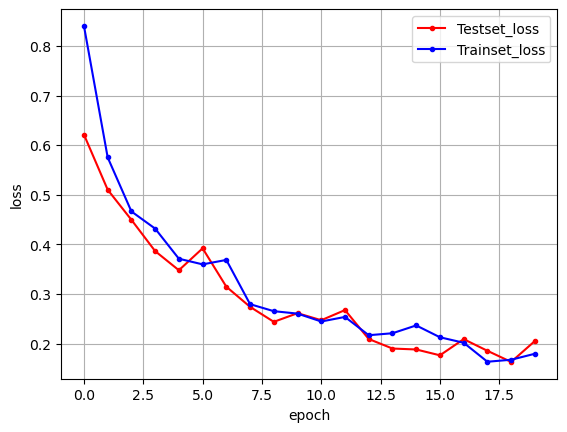

In [9]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()